# Song recommender

In [1]:
%matplotlib inline

import pandas
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
import Recommenders as Recommenders
import Evaluation as Evaluation

C:\Users\adity\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Loading music data

In [2]:
#Read userid-songid-listen_count triplets
#This step might take time to download data from external sources
triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

song_df_1 = pandas.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_df_2 =  pandas.read_csv(songs_metadata_file)

#Merge the two dataframes above to create input dataframe for recommender systems
song_df = pandas.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left") 

Dataset 


In [3]:
song_df.head(20)

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5,Apuesta Por El Rock 'N' Roll,Antología Audiovisual,Héroes del Silencio,2007
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODXRTY12AB0180F3B,1,Paper Gangsta,The Fame Monster,Lady GaGa,2008
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFGUAY12AB017B0A8,1,Stacked Actors,There Is Nothing Left To Lose,Foo Fighters,1999
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFRQTD12A81C233C0,1,Sehr kosmisch,Musik von Harmonia,Harmonia,0
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOHQWYZ12A6D4FA701,1,Heaven's gonna burn your eyes,Hôtel Costes 7 by Stéphane Pompougnac,Thievery Corporation feat. Emiliana Torrini,2002


In [4]:
len(song_df)

2000000

## Subset of the dataset

In [5]:
song_df = song_df.head(10000)

#Merge song title and artist_name columns to make a merged column
song_df['song'] = song_df['title'].map(str) + " - " + song_df['artist_name']

## Grouping The Dataset using listen count and percentage

Thus,giving us the most popular song on top

In [6]:
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])

,song,listen_count,percentage
3660,Sehr kosmisch - Harmonia,45,0.45
4678,Undo - Björk,32,0.32
5105,You're The One - Dwight Yoakam,32,0.32
1071,Dog Days Are Over (Radio Edit) - Florence + Th...,28,0.28
3655,Secrets - OneRepublic,28,0.28
4378,The Scientist - Coldplay,27,0.27
4712,Use Somebody - Kings Of Leon,27,0.27
3476,Revelry - Kings Of Leon,26,0.26
1387,Fireflies - Charttraxx Karaoke,24,0.24
1862,Horn Concerto No. 4 in E flat K495: II. Romanc...,23,0.23


## Checking no of unique user  and songs

In [7]:
users = song_df['user_id'].unique()

In [8]:
len(users)

365

In [9]:
###Fill in the code here
songs = song_df['song'].unique()
len(songs)

5151

# Creation of song recommender

In [10]:
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)
print(train_data.head(5))

                                       user_id             song_id  \
7389  94d5bdc37683950e90c56c9b32721edb5d347600  SOXNZOW12AB017F756   
9275  1012ecfd277b96487ed8357d02fa8326b13696a5  SOXHYVQ12AB0187949   
2995  15415fa2745b344bce958967c346f2a89f792f63  SOOSZAZ12A6D4FADF8   
5316  ffadf9297a99945c0513cd87939d91d8b602936b  SOWDJEJ12A8C1339FE   
356   5a905f000fc1ff3df7ca807d57edb608863db05d  SOAMPRJ12A8AE45F38   

      listen_count                 title  \
7389             2      Half Of My Heart   
9275             1  The Beautiful People   
2995             1     Sanctify Yourself   
5316             4     Heart Cooks Brain   
356             20                 Rorol   

                                                release      artist_name  \
7389                                     Battle Studies       John Mayer   
9275             Antichrist Superstar (Ecopac Explicit)   Marilyn Manson   
2995                             Glittering Prize 81/92     Simple Minds   
5316  Ever

In [11]:
#Recommenders.popularity_recommender_py

### Creating an instance of popularity based recommender class

In [12]:
pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

### Using the popularity model to make some predictions

In [13]:
user_id = users[5]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Sehr kosmisch - Harmonia,37,1.0
4083,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Undo - Björk,27,2.0
931,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,4bd88bfb25263a75bbdd467e74018f4ae570e5df,You're The One - Dwight Yoakam,24,4.0
3034,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Revelry - Kings Of Leon,21,5.0
3189,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Secrets - OneRepublic,21,6.0
4112,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Use Somebody - Kings Of Leon,21,7.0
1207,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Fireflies - Charttraxx Karaoke,20,8.0
1577,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hey_ Soul Sister - Train,19,9.0
1626,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


## User similarity based personalized recommender system

In [14]:
#Recommenders.item_similarity_recommender_py

### Creating an instance of User similarity based recommender class

In [15]:
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

### Using the personalized model to make some song recommendations

In [16]:
#Print the songs for the user in training data
user_id = users[5]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 4bd88bfb25263a75bbdd467e74018f4ae570e5df:
------------------------------------------------------------------------------------
Just Lose It - Eminem
Without Me - Eminem
16 Candles - The Crests
Speechless - Lady GaGa
Push It - Salt-N-Pepa
Ghosts 'n' Stuff (Original Instrumental Mix) - Deadmau5
Say My Name - Destiny's Child
My Dad's Gone Crazy - Eminem / Hailie Jade
The Real Slim Shady - Eminem
Somebody To Love - Justin Bieber
Forgive Me - Leona Lewis
Missing You - John Waite
Ya Nada Queda - Kudai
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 13
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2097


,user_id,song,score,rank
0,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Superman - Eminem / Dina Rae,0.088692,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Mockingbird - Eminem,0.067663,2
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm Back - Eminem,0.065385,3
3,4bd88bfb25263a75bbdd467e74018f4ae570e5df,U Smile - Justin Bieber,0.064525,4
4,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Here Without You - 3 Doors Down,0.062293,5
5,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hellbound - J-Black & Masta Ace,0.055769,6
6,4bd88bfb25263a75bbdd467e74018f4ae570e5df,The Seed (2.0) - The Roots / Cody Chestnutt,0.052564,7
7,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm The One Who Understands (Edit Version) - War,0.052564,8
8,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Falling - Iration,0.052564,9
9,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Armed And Ready (2009 Digital Remaster) - The ...,0.052564,10


In [17]:
user_id = users[7]
#Fill in the code here
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)


------------------------------------------------------------------------------------
Training data songs for the user userid: 9d6f0ead607ac2a6c2460e4d14fb439a146b7dec:
------------------------------------------------------------------------------------
Swallowed In The Sea - Coldplay
Life In Technicolor ii - Coldplay
Life In Technicolor - Coldplay
The Scientist - Coldplay
Trouble - Coldplay
Strawberry Swing - Coldplay
Lost! - Coldplay
Clocks - Coldplay
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 8
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :3429


,user_id,song,score,rank
0,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,She Just Likes To Fight - Four Tet,0.281579,1
1,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Warning Sign - Coldplay,0.281579,2
2,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,We Never Change - Coldplay,0.281579,3
3,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Puppetmad - Puppetmastaz,0.281579,4
4,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,God Put A Smile Upon Your Face - Coldplay,0.281579,5
5,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Susie Q - Creedence Clearwater Revival,0.281579,6
6,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,The Joker - Fatboy Slim,0.281579,7
7,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Korg Rhythm Afro - Holy Fuck,0.281579,8
8,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,This Unfolds - Four Tet,0.281579,9
9,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,high fives - Four Tet,0.281579,10


In [18]:
start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:319
Length of user sample:15
Getting recommendations for user:55e29789181da8b9c8e9d5f3b624a029492d7616
No. of unique songs for the user: 15
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2392
Getting recommendations for user:6beb4699102775dab57aa406c5ea1217c4ff4869
No. of unique songs for the user: 42
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :6181
Getting recommendations for user:399793ee5842e6f5b0b7f04fa5ec402454e2fe34
No. of unique songs for the user: 5
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2143
Getting recommendations for user:62f2f9b881dc320d745a90c0c10528d18e10deb1
No. of unique songs for the user: 9
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :1854
Getting recommendations for user:eb9d84c10ac4bffeb383a3a7c2d5207c93da4a84
No. of unique songs for the user: 16
no. of unique songs in th

## Precision recall curve

In [19]:
import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()


Plotting precision recall curves.


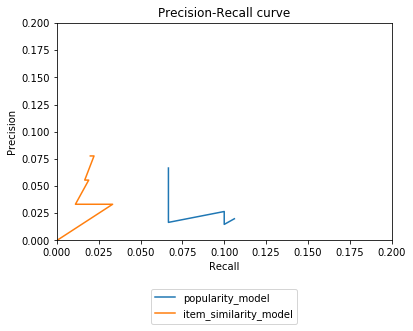

In [20]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")


### Generate Precision Recall curve using pickled results on a larger data subset(Python 3)

Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).
Plotting precision recall curves.


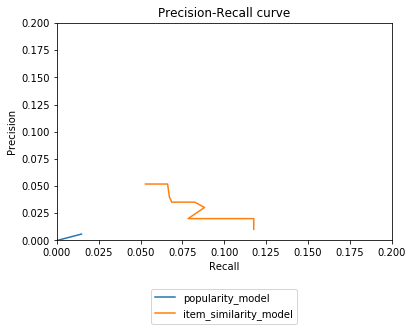

In [21]:
print("Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).")

#Read the persisted files 
pm_avg_precision_list = joblib.load('pm_avg_precision_list_3.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_3.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_3.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_3.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")